#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation



Download necessary NLTK resources

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Generate mock product review data

In [ ]:
np.random.seed(42)
num_reviews = 1000
products = [f'Product_{chr(65+i)}' for i in range(5)] # Product_A, Product_B, ...
users = [f'User_{100+i}' for i in range(100)]
positive_phrases = [
    "love this product", "excellent quality", "works perfectly", "highly recommend",
    "great value", "very satisfied", "easy to use", "fantastic", "amazing features",
    "best purchase ever", "exceeded expectations", "five stars", "wonderful experience"]
negative_phrases = [
    "terrible product", "poor quality", "does not work", "would not recommend",
    "waste of money", "very disappointed", "difficult to use", "awful", "missing features",
    "worst purchase", "broke easily", "one star", "bad experience", "customer service was bad"]
neutral_phrases = [
    "it's okay", "average product", "works as expected", "nothing special", "decent for the price",
    "met expectations", "neither good nor bad", "could be better", "some pros and cons"]
review_data = []
current_date = datetime(2023, 1, 1)
for i in range(num_reviews):
    rating = np.random.randint(1, 6)
    product_id = np.random.choice(products)
    user_id = np.random.choice(users)
    review_date = current_date + timedelta(days=np.random.randint(0, 365*2)) # Reviews over 2 years
    if rating >= 4:
        text = f"{np.random.choice(positive_phrases)}. {np.random.choice(positive_phrases)}."
        if np.random.rand() < 0.3: text += f" {np.random.choice(neutral_phrases)}."
    elif rating <= 2:
        text = f"{np.random.choice(negative_phrases)}. {np.random.choice(negative_phrases)}."
        if np.random.rand() < 0.3: text += f" {np.random.choice(neutral_phrases)}."
    else: # rating == 3
        text = f"{np.random.choice(neutral_phrases)}. "
        if np.random.rand() < 0.5: text += f"{np.random.choice(positive_phrases)}."
        else: text += f"{np.random.choice(negative_phrases)}."
    review_data.append({
        'ReviewID': f'REV{2000+i}',
        'ProductID': product_id,
        'UserID': user_id,
        'Rating': rating,
        'ReviewText': text,
        'ReviewDate': review_date.strftime('%Y-%m-%d')
    })

df_reviews = pd.DataFrame(review_data)

Save to CSV

In [ ]:
df_reviews.to_csv('product_reviews_mock_data.csv', index=False)
df_reviews.head()

,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,2023-04-17
1,REV2001,Product_C,User_186,2,broke easily. awful.,2023-11-27
2,REV2002,Product_E,User_101,3,met expectations. five stars.,2023-12-10
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,2023-11-10
4,REV2004,Product_C,User_158,1,worst purchase. one star.,2024-05-25


#Initial Exploration

Display basic structure

In [ ]:
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ReviewID           1000 non-null   object        
 1   ProductID          1000 non-null   object        
 2   UserID             1000 non-null   object        
 3   Rating             1000 non-null   int64         
 4   ReviewText         1000 non-null   object        
 5   ReviewDate         1000 non-null   datetime64[ns]
 6   CleanedReviewText  1000 non-null   object        
 7   SentimentScore     1000 non-null   float64       
 8   SentimentLabel     1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 70.4+ KB


Display column names and sample values

In [ ]:
columns = df_reviews.columns.tolist()
sample_values = df_reviews.sample(5)
columns, sample_values

(['ReviewID', 'ProductID', 'UserID', 'Rating', 'ReviewText', 'ReviewDate'],
     ReviewID  ProductID    UserID  Rating  \
 99   REV2099  Product_C  User_144       1   
 736  REV2736  Product_C  User_161       5   
 318  REV2318  Product_C  User_108       1   
 948  REV2948  Product_B  User_124       5   
 404  REV2404  Product_A  User_171       4   
 
                                          ReviewText  ReviewDate  
 99   would not recommend. customer service was bad.  2024-12-17  
 736               highly recommend. very satisfied.  2023-08-09  
 318               waste of money. missing features.  2023-04-09  
 948                 five stars. best purchase ever.  2023-10-27  
 404              works perfectly. highly recommend.  2024-10-01  )

#Text Preprocessing

Initialize preprocessing tools

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Define text preprocessing function

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
df_reviews['CleanedReviewText'] = df_reviews['ReviewText'].apply(preprocess_text)
df_reviews[['ReviewText', 'CleanedReviewText']].head()

,ReviewText,CleanedReviewText
0,fantastic. wonderful experience.,fantastic wonderful experience
1,broke easily. awful.,broke easily awful
2,met expectations. five stars.,met expectation five star
3,very satisfied. wonderful experience.,satisfied wonderful experience
4,worst purchase. one star.,worst purchase one star


#Sentiment Analysis

Function to get sentiment polarity score and label

In [ ]:
def get_sentiment_score(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

def categorize_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

Apply sentiment scoring and labeling

In [ ]:
df_reviews['SentimentScore'] = df_reviews['CleanedReviewText'].apply(get_sentiment_score)
df_reviews['SentimentLabel'] = df_reviews['SentimentScore'].apply(categorize_sentiment)
display(df_reviews[['ReviewText', 'CleanedReviewText', 'SentimentScore', 'SentimentLabel']].head(10))

,ReviewText,CleanedReviewText,SentimentScore,SentimentLabel
0,fantastic. wonderful experience.,fantastic wonderful experience,0.700000,Positive
1,broke easily. awful.,broke easily awful,-1.000000,Negative
2,met expectations. five stars.,met expectation five star,0.000000,Neutral
3,very satisfied. wonderful experience.,satisfied wonderful experience,0.750000,Positive
4,worst purchase. one star.,worst purchase one star,-1.000000,Negative
5,some pros and cons. works perfectly.,pro con work perfectly,1.000000,Positive
6,highly recommend. amazing features.,highly recommend amazing feature,0.380000,Positive
7,waste of money. poor quality.,waste money poor quality,-0.300000,Negative
8,love this product. highly recommend. nothing s...,love product highly recommend nothing special,0.339048,Positive
9,poor quality. worst purchase.,poor quality worst purchase,-0.700000,Negative


#Exploratory Data Analysis of Sentiments

Sentiment distribution

/tmp/ipython-input-34-2776829626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_reviews, x='SentimentLabel', palette='Set2')


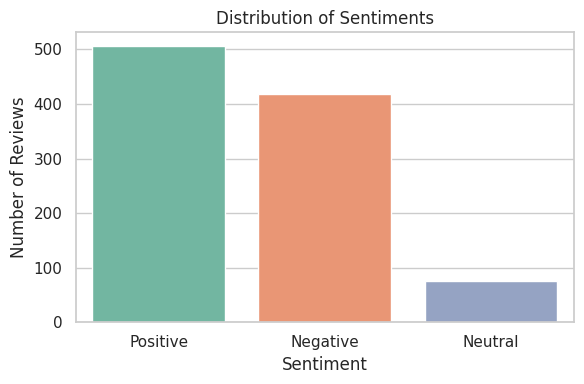

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=df_reviews, x='SentimentLabel', palette='Set2')
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

Create word clouds for positive and negative reviews

In [ ]:
positive_reviews = " ".join(df_reviews[df_reviews['SentimentLabel'] == 'Positive']['ReviewText'])
negative_reviews = " ".join(df_reviews[df_reviews['SentimentLabel'] == 'Negative']['ReviewText'])

Generate word clouds

In [ ]:
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

Plot word cloud for positive reviews

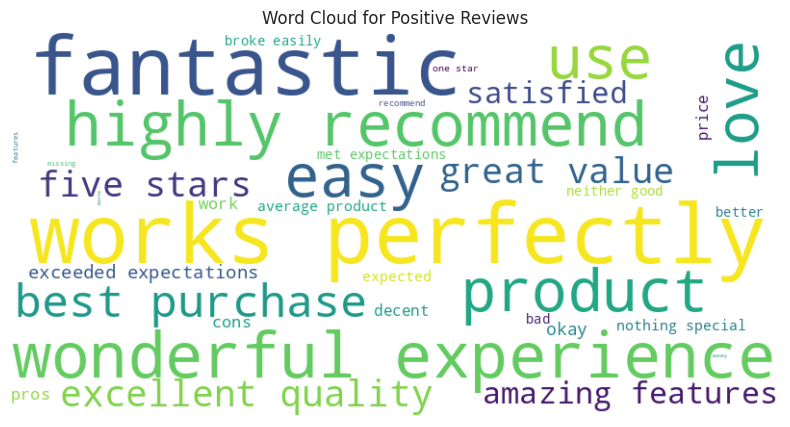

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

Plot word cloud for negative reviews

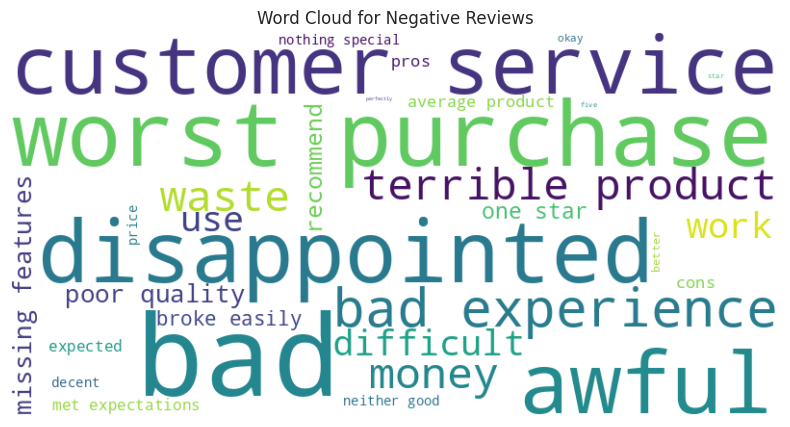

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

Sentiment Trends Over Time

<Figure size 1200x600 with 0 Axes>

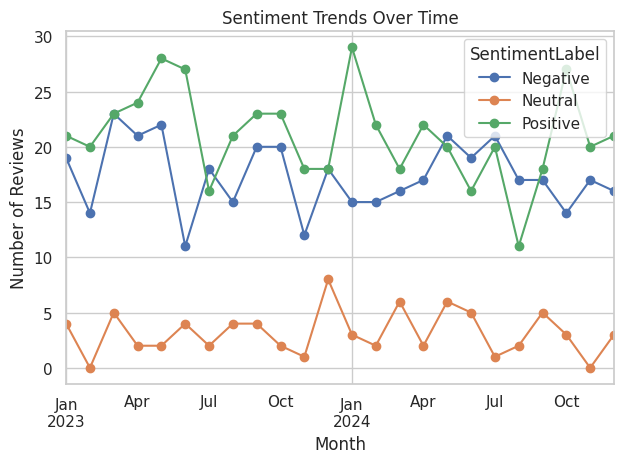

In [ ]:
df_reviews['ReviewDate'] = pd.to_datetime(df_reviews['ReviewDate'])
sentiment_over_time = df_reviews.groupby([df_reviews['ReviewDate'].dt.to_period('M'), 'SentimentLabel']).size().unstack().fillna(0)
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

plt.figure(figsize=(12, 6))
sentiment_over_time.plot(kind='line', marker='o')
plt.title("Sentiment Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.tight_layout()
plt.show()

Sentiment by Product

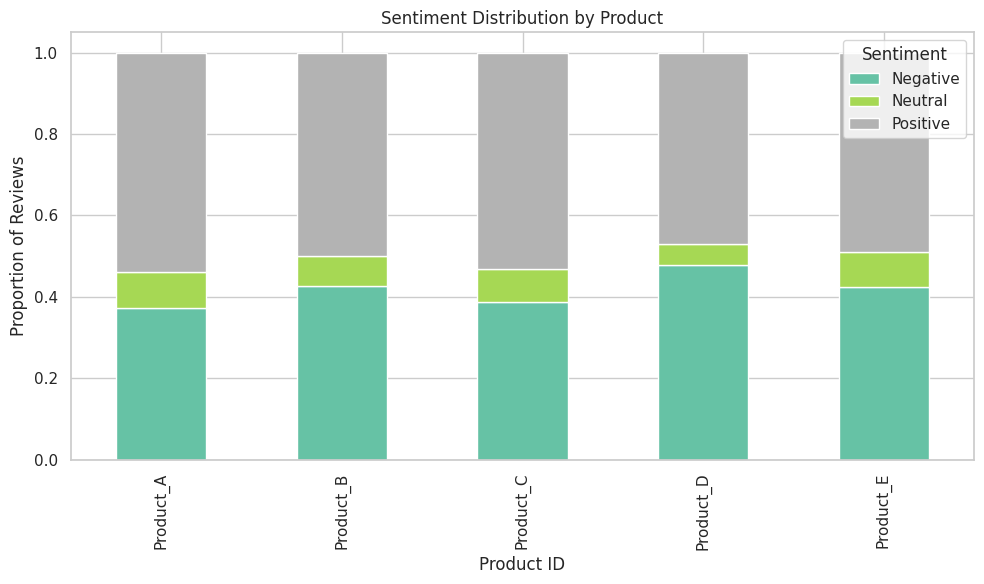

In [ ]:
sentiment_by_product = df_reviews.groupby(['ProductID', 'SentimentLabel']).size().unstack().fillna(0)
sentiment_by_product_percent = sentiment_by_product.div(sentiment_by_product.sum(axis=1), axis=0)
sentiment_by_product_percent.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title("Sentiment Distribution by Product")
plt.xlabel("Product ID")
plt.ylabel("Proportion of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#Topic Modeling

Focus on negative reviews

In [ ]:
negative_texts = df_reviews[df_reviews['SentimentLabel'] == 'Negative']['ReviewText']

TF-IDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(negative_texts)

Apply NMF for topic modeling

In [ ]:
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

NMF(n_components=5, random_state=42)

Extract feature names

In [ ]:
feature_names = vectorizer.get_feature_names_out()

Display top words for each topic

In [ ]:
topics = {}
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topics[f"Topic {topic_idx+1}"] = top_features
topics_df = pd.DataFrame.from_dict(topics, orient='index', columns=[f"Word {i+1}" for i in range(10)])

display(topics_df)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,bad,service,customer,experience,recommend,easily,broke,good,star,pros
Topic 2,worst,purchase,star,does,work,better,pros,cons,decent,price
Topic 3,product,terrible,average,easily,broke,disappointed,awful,works,expected,special
Topic 4,use,difficult,missing,features,awful,work,does,good,easily,broke
Topic 5,waste,money,quality,poor,disappointed,recommend,awful,star,expectations,met


Use all review texts

In [ ]:
all_reviews = df_reviews['ReviewText']

Vectorize using CountVectorizer for LDA

In [ ]:
vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer_lda.fit_transform(all_reviews)

 Apply LDA

In [ ]:
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

Extract feature names

In [ ]:
lda_feature_names = vectorizer_lda.get_feature_names_out()

Display top words for each topic

In [ ]:
lda_topics = {}
for topic_idx, topic in enumerate(lda_model.components_):
    top_features = [lda_feature_names[i] for i in topic.argsort()[:-11:-1]]
    lda_topics[f"Topic {topic_idx+1}"] = top_features

Convert to DataFrame for display

In [ ]:
lda_topics_df = pd.DataFrame.from_dict(lda_topics, orient='index', columns=[f"Word {i+1}" for i in range(10)])
display(lda_topics_df)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,expectations,recommend,highly,purchase,best,pros,cons,exceeded,met,work
Topic 2,works,perfectly,stars,features,amazing,expected,fantastic,product,love,value
Topic 3,worst,missing,features,broke,easily,disappointed,awful,purchase,waste,money
Topic 4,bad,experience,product,wonderful,customer,service,terrible,good,average,recommend
Topic 5,use,quality,easy,difficult,excellent,poor,special,waste,money,product


Exact Sentiment Counts Per Product

In [ ]:
sentiment_counts = df_reviews.groupby(['ProductID', 'SentimentLabel']).size().unstack(fill_value=0)
top_reviews = {}

for product in df_reviews['ProductID'].unique():
    top_pos = df_reviews[(df_reviews['ProductID'] == product) & (df_reviews['SentimentLabel'] == 'Positive')].sort_values(by='SentimentScore', ascending=False).head(1)
    top_neg = df_reviews[(df_reviews['ProductID'] == product) & (df_reviews['SentimentLabel'] == 'Negative')].sort_values(by='SentimentScore').head(1)
    top_reviews[product] = {
        "Top Positive Review": top_pos['ReviewText'].values[0] if not top_pos.empty else "N/A",
        "Top Negative Review": top_neg['ReviewText'].values[0] if not top_neg.empty else "N/A"
    }

top_reviews_df = pd.DataFrame(top_reviews).T

Correlation between Rating and Sentiment Score

In [ ]:
correlation = df_reviews[['Rating', 'SentimentScore']].corr().loc['Rating', 'SentimentScore']
display(sentiment_counts)

SentimentLabel,Negative,Neutral,Positive
ProductID,,,
Product_A,76,18,110
Product_B,80,14,94
Product_C,80,17,110
Product_D,104,11,102
Product_E,78,16,90


In [ ]:
display(top_reviews_df)

,Top Positive Review,Top Negative Review
Product_E,works perfectly. excellent quality.,awful. would not recommend.
Product_C,exceeded expectations. works perfectly.,broke easily. awful.
Product_A,works perfectly. best purchase ever.,does not work. awful.
Product_D,some pros and cons. works perfectly.,awful. one star.
Product_B,wonderful experience. five stars.,one star. worst purchase.


#Summary statistics

In [ ]:
total_reviews = len(df_reviews)
sentiment_distribution = df_reviews['SentimentLabel'].value_counts()
most_positive_product = df_reviews[df_reviews['SentimentLabel'] == 'Positive']['ProductID'].value_counts().idxmax()
most_negative_product = df_reviews[df_reviews['SentimentLabel'] == 'Negative']['ProductID'].value_counts().idxmax()

Top words from earlier LDA topic modeling (from all reviews)

In [ ]:
top_topics_summary = lda_topics_df.apply(lambda row: ', '.join(row.values), axis=1).to_dict()

Prepare findings and recommendations

In [ ]:
summary = {
    "Total Reviews Analyzed": total_reviews,
    "Sentiment Distribution": sentiment_distribution.to_dict(),
    "Product with Most Positive Reviews": most_positive_product,
    "Product with Most Negative Reviews": most_negative_product,
    "Key Topics Identified": top_topics_summary,
    "Common Positive Aspects": [
        "recommend", "perfectly", "excellent", "best", "fantastic"
    ],
    "Major Pain Points": [
        "worst", "broke", "missing features", "poor quality", "waste of money"
    ],
    "Recommendations": [
        "Investigate issues in product '{}' due to high negative sentiment.".format(most_negative_product),
        "Promote product '{}' as it received the most positive feedback.".format(most_positive_product),
        "Improve product quality control to reduce breakage and missing features.",
        "Enhance customer service based on frequent mentions in complaints.",
        "Leverage positive feedback keywords in marketing strategies."
    ]
}

Display summary as DataFrame for clarity

In [ ]:
summary_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in summary.items()]))
display(summary_df)

,Total Reviews Analyzed,Sentiment Distribution,Product with Most Positive Reviews,Product with Most Negative Reviews,Key Topics Identified,Common Positive Aspects,Major Pain Points,Recommendations
0,1000.0,NaN,Product_A,Product_D,NaN,recommend,worst,Investigate issues in product 'Product_D' due ...
1,NaN,NaN,NaN,NaN,NaN,perfectly,broke,Promote product 'Product_A' as it received the...
2,NaN,NaN,NaN,NaN,NaN,excellent,missing features,Improve product quality control to reduce brea...
3,NaN,NaN,NaN,NaN,NaN,best,poor quality,Enhance customer service based on frequent men...
4,NaN,NaN,NaN,NaN,NaN,fantastic,waste of money,Leverage positive feedback keywords in marketi...
Negative,NaN,418.0,NaN,NaN,NaN,NaN,NaN,NaN
Neutral,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN
Positive,NaN,506.0,NaN,NaN,NaN,NaN,NaN,NaN
Topic 1,NaN,NaN,NaN,NaN,"expectations, recommend, highly, purchase, bes...",NaN,NaN,NaN
Topic 2,NaN,NaN,NaN,NaN,"works, perfectly, stars, features, amazing, ex...",NaN,NaN,NaN
